# Import packages

In [1]:
from array import array
import itertools
import time
import math

import rootpy.plotting.root2matplotlib as rplt
from rootpy.plotting.style import get_style, set_style
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import matplotlib.pyplot as plt
import numpy as np

import astroML.plotting as aml
import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from matplotlib.ticker import NullFormatter

Welcome to JupyROOT 6.13/01


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:252: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


# File

In [2]:
RootFile = 'Same_Mix_Ratio_v1.root'
#RootFile = 'Mix_Correlation_TPCISO.root'
#RootFile = 'Same_Event_Correlation_13defv1.root'
#RootFile = 'Combined_TrackSkim_Mix_Correlation.root'
#RootFile = 'Combined_TrackSkim_Mix_Correlation_v1.root'
#RootFile = 'Mix_Correlation_0GeVTracks_13defv1_ALL.root'

# Define Bins

In [3]:
#FIXME: Read from Corr_config.yaml
zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
pTbins = [10, 11, 12.5, 16]

# Plot Titles

In [4]:
def Plot1D (histo, ptbin, ztbin,DNN_Bool):
    histo.SetTitle("#gamma-hadron: p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"
                   %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    histo.GetXaxis().SetTitle("#Delta#eta")
    histo.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    histo.GetYaxis().SetTitleOffset(1)
    ROOT.gStyle.SetOptStat("")
    if not(DNN_Bool):
        histo.SetLineColor(2)

In [5]:
def Plot2D (histo2D,ptbin,ztbin,DNN_Bool):
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
    histo2D.GetXaxis().SetTitle("#Delta#phi")
    histo2D.GetYaxis().SetTitle("#Delta#eta")
    histo2D.GetZaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    histo2D.SetTitle('#gamma-hadron: DNN%i pT (%1.0f-%1.0f) zT (%1.2f-%1.2f)' 
                       %(DNN_Rgn,pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    histo2D.GetYaxis().SetRangeUser(-1.2,1.2)
    histo2D.GetZaxis().SetTitleOffset(2)
    #ROOT.gStyle.SetOptStat("")

# 2D Correlations

In [6]:
def Get2D(filename, ipt, izt, Signal_DNN=True):

    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    histoDNN = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))
    histoDNN.SetTitle('Mix Events [High DNN] pT (%1.0f-%1.0f) zT (%1.2f-%1.2f)' 
                       %(pTbins[ipt],pTbins[ipt+1],zTbins[izt],zTbins[izt+1]))
       
    histoDNN.SetDirectory(0)
    Plot2D(histoDNN,ipt,izt,Signal_DNN)
    
    file.Close()
    return histoDNN

In [7]:
def Loop2D(filename,Signal_DNN=True):
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
    canvases = []
    for ipt in range(3):
        canvases.append(ROOT.TCanvas("Canvas%i"%(ipt),"Canvas",6000,3500))
        canvases[ipt].Divide(3,2)
        for izt in range(6):
            histoDNN = Get2D(filename,ipt,izt,Signal_DNN)
            canvases[ipt].cd(izt+1)
            gpad1 = canvases[ipt].cd(izt+1)
            gpad1.SetLeftMargin(0.15)
            histoDNN.Draw("SURF2")
            canvases[ipt].SetLeftMargin(0.15)
    return canvases


1


INFO:ROOT.TCanvas.Print] png file pics/2DCorrelations_CombinedGeV_ptBins_0.png has been created
INFO:ROOT.TCanvas.Print] png file pics/2DCorrelations_CombinedGeV_ptBins_1.png has been created
INFO:ROOT.TCanvas.Print] png file pics/2DCorrelations_CombinedGeV_ptBins_2.png has been created


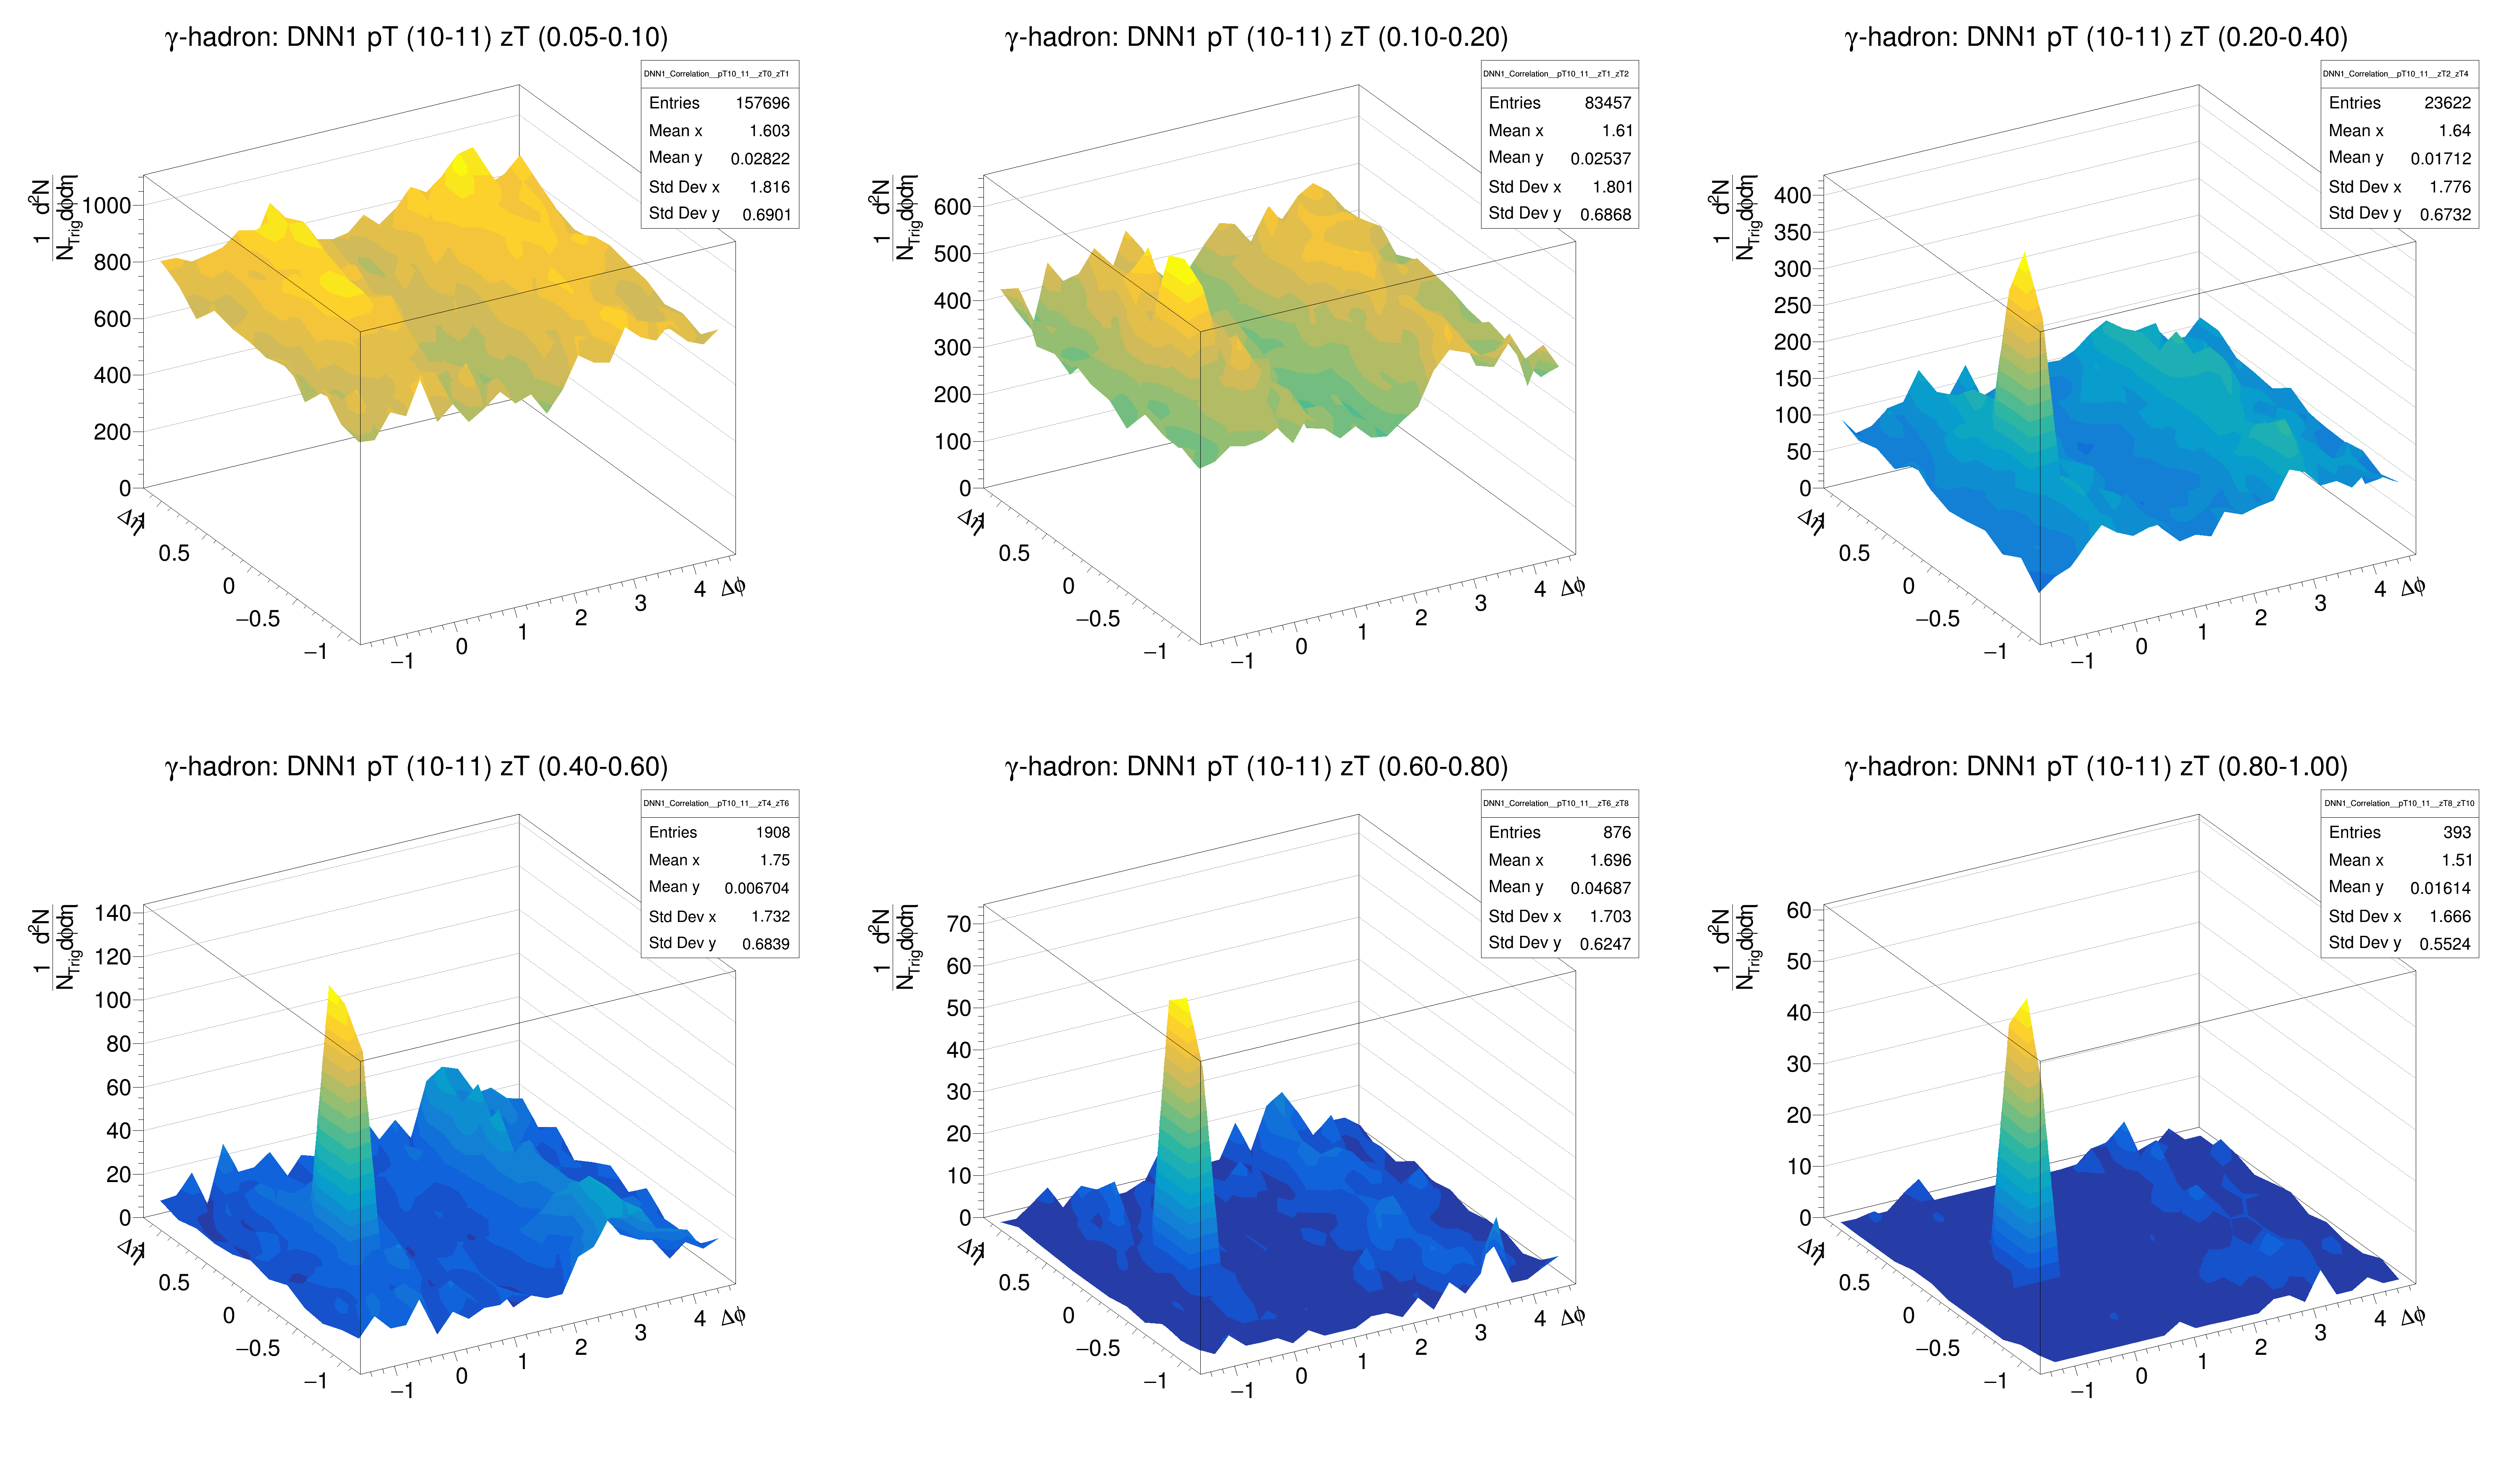

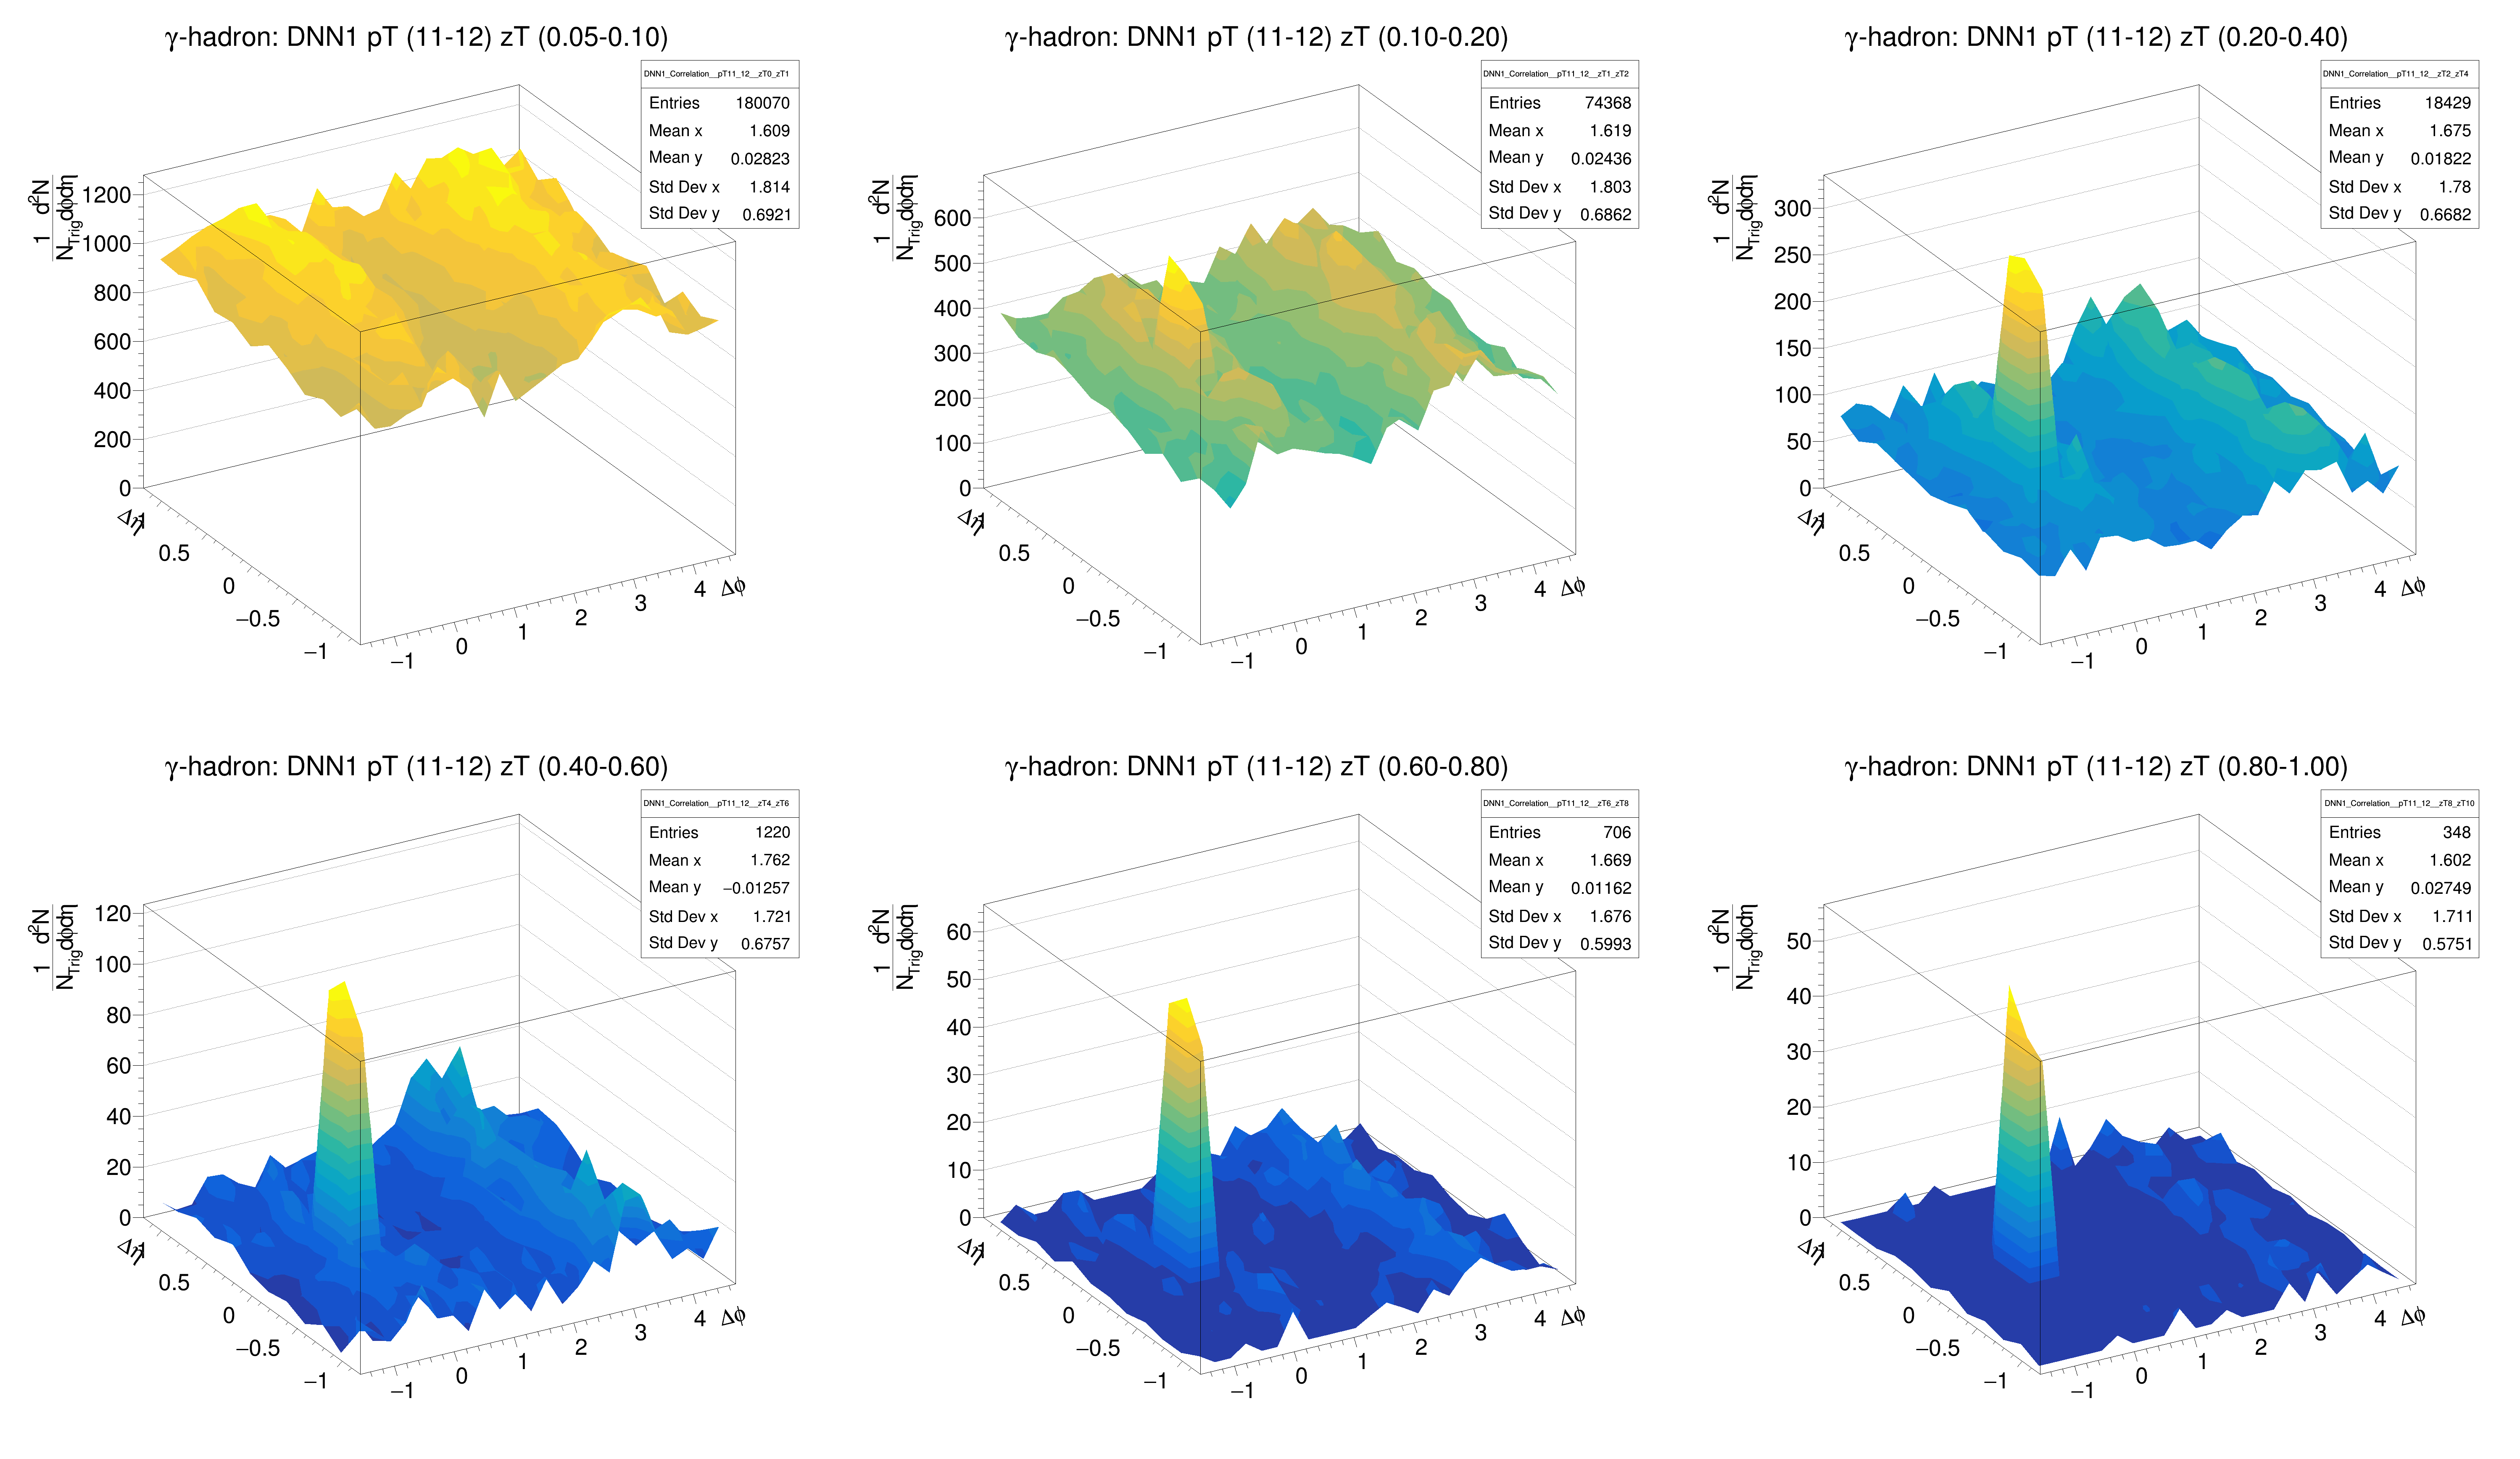

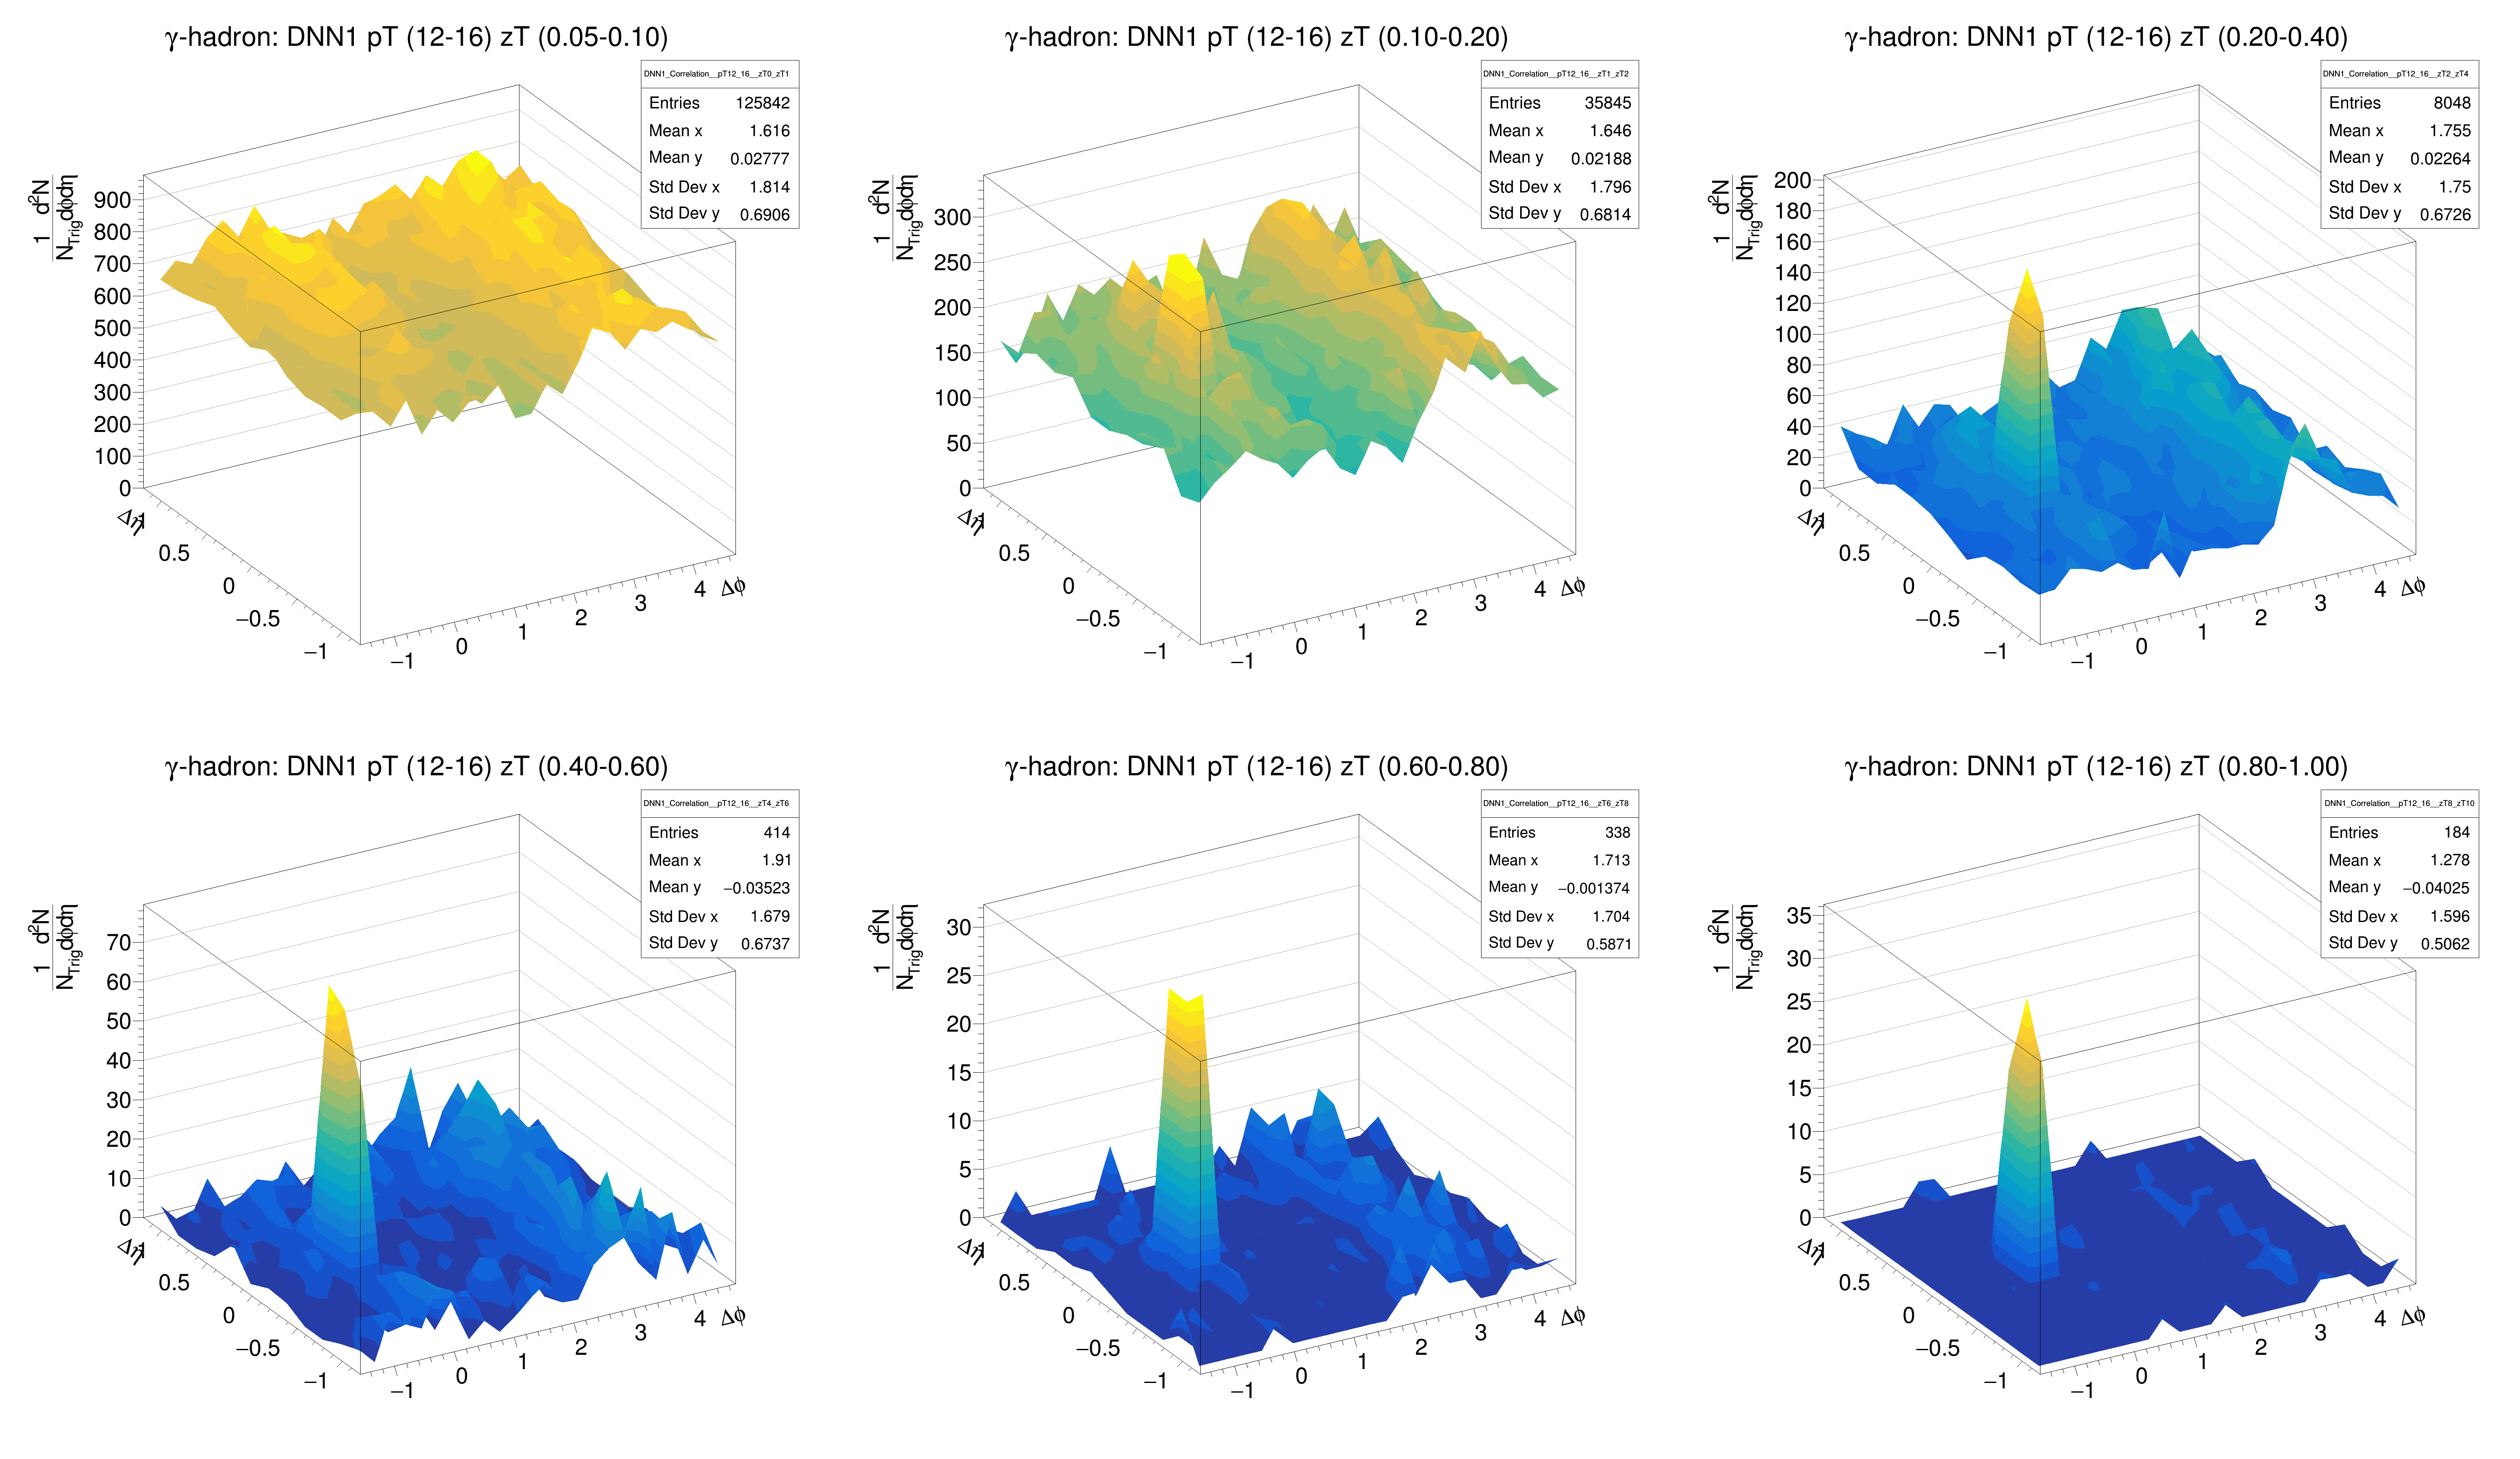

In [8]:
Signal_DNN = True
DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
print (DNN_Rgn)
canvases = Loop2D(RootFile,Signal_DNN)
ROOT.disableJSVis()
for ipt in range(3):
    canvases[ipt].Draw()
    canvases[ipt].SaveAs('pics/2DCorrelations_CombinedGeV_ptBins_%i.png'%(ipt))

# Phi Projection

<sup>**NOTE**: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

In [9]:
def GetPhiProj(filename, ipt, izt, Signal_DNN=True):

    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))
    #integra
    Eta_Axis = histo2D.GetYaxis()
    PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6));
    PhiProjection.SetDirectory(0)
    PhiProjection.Scale(1.0/1.2) #scale by eta region
    
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)
    
    zyam = PhiProjection.Integral(11,13)/3
    # how do I plot ZYAM, perhaps in both cases?
    #print('ZYAM=%f'%(zyam))
  
    file.Close()
    return PhiProjection

# Eta Projection

In [10]:
def GetEtaProj(filename, ipt, izt, Signal_DNN=True):

    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))
    #integral
    Phi_Axis = histo2D.GetXaxis()
    EtaProjection = histo2D.ProjectionY('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Phi_Axis.FindBin(-math.pi/2),Phi_Axis.FindBin(math.pi/2));
    EtaProjection.SetDirectory(0)
    EtaProjection.Scale(1.0/1.2) #scale by eta region
    
    Plot1D(EtaProjection,ipt,izt,Signal_DNN)
    
    #zyam = EtaProjection.Integral(11,13)/3
    # how do I plot ZYAM, perhaps in both cases?
    #print('ZYAM=%f'%(zyam))
  
    file.Close()
    return EtaProjection

INFO:ROOT.TCanvas.Print] png file pics/Eta_Proj_Trigger_pt_0.png has been created
INFO:ROOT.TCanvas.Print] png file pics/Eta_Proj_Trigger_pt_1.png has been created
INFO:ROOT.TCanvas.Print] png file pics/Eta_Proj_Trigger_pt_2.png has been created


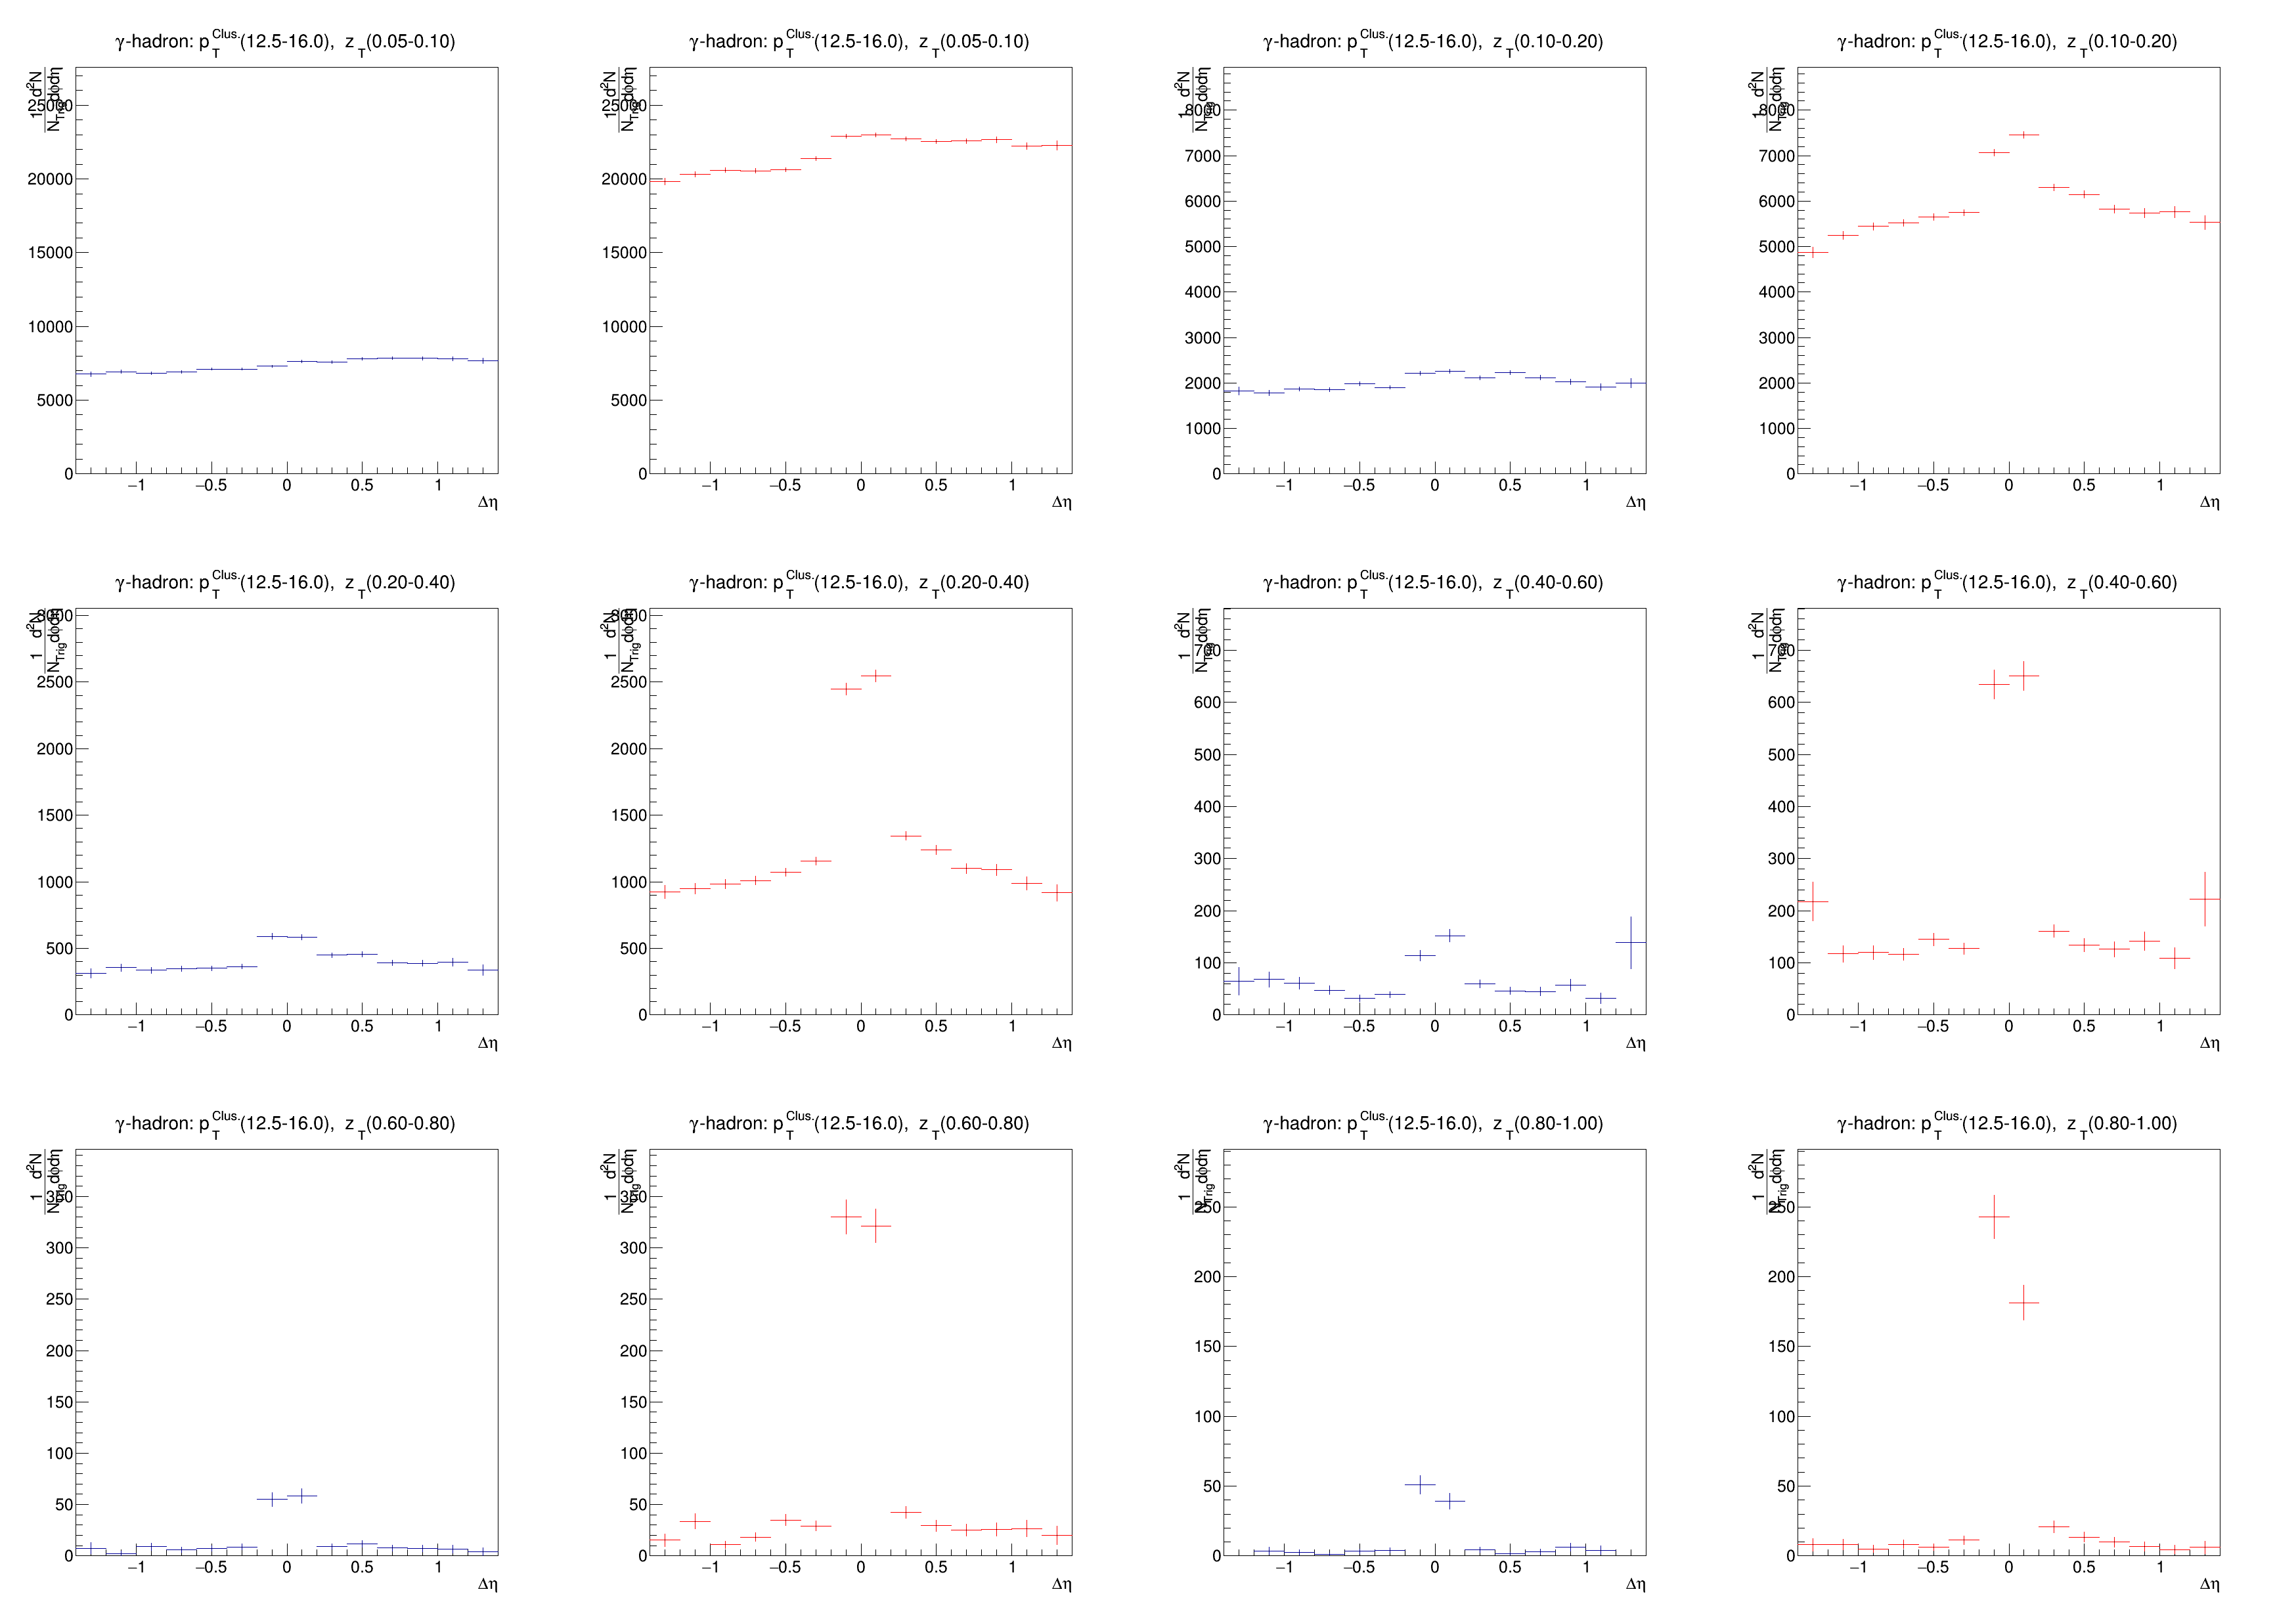

In [11]:
for ptbin in range(3):
    canvases = ROOT.TCanvas("canv_phi","canv_phi",3500,2500)
    canvases.Divide(4,3)
    
    for ztbin in range(6):
    
        #grab
        hsig = GetEtaProj(RootFile,ptbin,ztbin,True) #no subtraction, change DNN
        hbkg = GetEtaProj(RootFile,ptbin,ztbin,False)
 
        #same scale
        ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
        hsig.GetYaxis().SetRangeUser(0,ymax)
        hbkg.GetYaxis().SetRangeUser(0,ymax)    
    
        #Signal
        canvases.cd(ztbin*2+1)
        hsig.Draw()
        
        #Sig_ZYAM= ZYAM_Line(hsig) #Change to UnCorr_Line, swith to high rapidity
        #Sig_ZYAM.Draw("same")
        #LE_sig,legend = GetLEProj(RootFile, ptbin, ztbin,True)
        #LE_Line,temp = GetLE_Line(LE_sig)
        #legend.AddEntry(Sig_ZYAM, "ZYAM","l")
        #LE_sig.Draw("same")
        hsig.Draw("same")
        #legend.AddEntry(hsig,"High DNN","l")
        #legend.Draw("same")
    
        #Background
        canvases.cd(ztbin*2+2)
        hbkg.Draw()
        #BKG_ZYAM = ZYAM_Line(hbkg)
        #BKG_ZYAM.Draw("same")
        #LE_bkg,legend = GetLEProj(RootFile, ptbin, ztbin, False)
        #LE_bkg_Line,temp = GetLE_Line(LE_bkg)
        #legend.AddEntry(BKG_ZYAM, "ZYAM","l")
        #LE_bkg.Draw("same")
        hbkg.Draw("same")
        #legend.AddEntry(hbkg,"Low DNN","l")
        #legend.Draw("same")
    
    canvases.Draw()   
    canvases.SaveAs("pics/Eta_Proj_Trigger_pt_%i.png"%(ptbin))
#myText(.2,.2,"hello_%i"%number,1)